In [1]:
import os
import cv2
import numpy as np
from CellClass import evaluate_segmentation as eval
from natsort import natsorted
import matplotlib.pyplot as plt
import seaborn as sb

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata"
files = natsorted([x for x in os.listdir(base) if ".png" in x])

for file in files:
    if "SIMON" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"simon"))
    elif "FIKRET" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"fikret"))
        

In [2]:
from tqdm import tqdm
import pandas as pd

bases = ["/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/simon", "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/fikret"]

for base, observer in zip(bases, ["observer0", "observer1"]):
    files = natsorted([x for x in os.listdir(base) if ".png" in x])

    samples = []
    for file in tqdm(files):
        sample = file.split("-")[0]
        im = eval.remove_boarder(eval.load_segmentation(os.path.join(base, file)))
        samples.append({"name": sample, "im": im})

    locals()[observer] = pd.DataFrame(samples)

100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


In [3]:
base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/dapi"
files = natsorted([x for x in os.listdir(base) if ".tif" in x.lower()])

samples = []
for file in tqdm(files):
    sample = file.split(".")[0]
    im = cv2.imread(os.path.join(base, file), 0)
    samples.append({"name": sample, "im": im})

locals()["dapi"] = pd.DataFrame(samples)

100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


In [6]:
from CellClass.Segment import Segmentation

CP = Segmentation("deepcell")

In [7]:
dfs = []
for _, row in dapi.iterrows():
    _, mask = CP(row.im, image_mpp=0.45)
    dfs.append({"name": row["name"], "dapi": row.im, "im": eval.remove_boarder(mask)})

/home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [8]:
predictions = pd.DataFrame(dfs)

DAPI_0


100%|██████████| 330/330 [00:45<00:00,  7.26it/s]


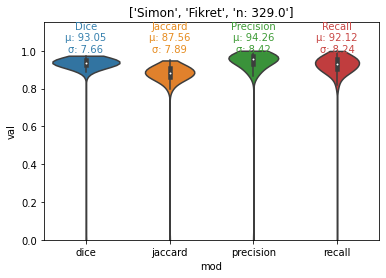

DAPI_0


100%|██████████| 330/330 [00:44<00:00,  7.38it/s]


DAPI_1


100%|██████████| 447/447 [01:02<00:00,  7.13it/s]


DAPI_2


100%|██████████| 348/348 [00:48<00:00,  7.18it/s]


DAPI_3


100%|██████████| 456/456 [01:03<00:00,  7.14it/s]


DAPI_4


100%|██████████| 358/358 [00:51<00:00,  7.00it/s]


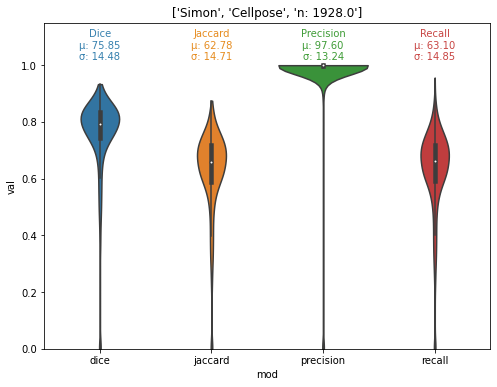

DAPI_0


100%|██████████| 338/338 [00:45<00:00,  7.37it/s]


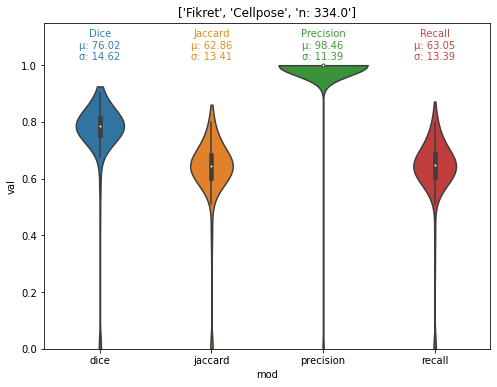

In [9]:
def compare_segmentations(df0, df1, title):

    rets = []
    for _, row in df0.iterrows():
        if any(df1['name'].str.contains(row["name"])):
            print(row["name"])
            seg0 = row["im"]
            seg1 = df1[df1["name"]==row["name"]].im.item()
            rets.extend(eval.compare_segmentations(seg0, seg1))
            
    df = pd.DataFrame(rets)
    d = []
    for n in natsorted(df["mod"].unique()):
        tmp = df[df["mod"] == n]
        d.append({
            "mean": tmp.val.mean(),
            "std": tmp.val.std(),
            "measure": n,
            })
                
    plt.rcParams["figure.figsize"] = 8,6
    ax = sb.violinplot(x="mod", y="val", data=df, cut=0)
    ax.set_ylim(0, 1.15)

    for info, n, c, val in zip(d, np.linspace(0,3,4), ["#3680AE", "#E68C20", "#3F9C37", "#C84644"], [f"Dice", f"Jaccard",f"Precision",f"Recall"]):
        plt.text(n, 1.07, f"{val}\nµ: {info['mean']*100:.2f}\nσ: {info['std']*100:.2f}", ha="center", va="center", c=c)
       
    ax.set_title([*title, f"n: {len(rets)/4}"])  
    plt.show()   
                
compare_segmentations(observer0, observer1, ["Simon", "Fikret"])  
compare_segmentations(observer0, predictions, ["Simon", "Cellpose"])  
compare_segmentations(observer1, predictions, ["Fikret", "Cellpose"])  